# Information Exploration Final - Exploratory Data Analysis

### Introduction
This is my submission for the Information Exploration (INFO 3401) Final assignment. In this jupyter notebook, I will set out to uncover and correct any of the dataset's quality issues, explore the dataset's features with visualizations, formulate a testable hypothesis from the data exploration, and finally test my hypothesis and discuss the results.

The [dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) for this assignment comes from the UC Irving Machine Learning Repository, however I will be using the modified copy of the dataset supplied via canvas by Dr. Shah. <br><br>According to the table available in the dataset's link, several characteristics of the original, unprocessed dataset are described:
<ul>
    <li>The dataset is multivariate.</li>
    <li>The dataset contains categorical, integer, and real data-types.</li>
    <li>This dataset is associated with classification tasks in machine learning.</li>
    <li>There are 303 records with 75 attributes.</li>
    <li>The (unprocessed) dataset contains missing values.</li>
    <li>This dataset was donated to the repository 1988-07-01.</li>
    <li>The number of time people have accessed this dataset online is <strong>2,042,644</strong>.</li>
</ul>
<br>

<strong>Table of Contents:</strong>

    Section 0: Functions
    Section 1: Exploratory Analysis and Cleaning
        Subsection 1: ETL - Extract Transform Load
            Step 0: Load libraries
            Step 1: Formulate a Question
            Step 2: Load in the dataset
            Step 3: Check the packaging
            Step 4: Heads and Tails
            Step 5: Nulls values and Corrections
                5.1: Any null values?
                5.2: Any duplicates?
                5.3: Any outliers?
                5.4: Any non-sense zeroes?
            Step 6: Validate the dataset with an outside source
        
        Subsection 2: Data Visualization
            Step 7: Make plots
            Step 8: Try an easy solution first

    Section 2: Hypothesis Testing
        Step 0: Subset the continuous variables
        Step 1: Compute covariance between continuous variables
            1.1: Covariance explanation
        Step 2: Compute the correlation between continuous variables
            2.1: Correlation explanation
        Step 3: Select the continuous variables which are the most positively correlated.
        Step 4: Null Hypothesis

    Section 3: Conclusions

## Section 0: Functions

In [1]:
# Functions defined for this assignment
def remove_outliers(dataset, q1 = 0.25, q3 = 0.75):
    Q1 = dataset.quantile(q1)
    Q3 = dataset.quantile(q3)
    IQR = Q3 - Q1
    lower_outliers = Q1 - (1.5 * IQR)
    upper_outliers = Q3 + (1.5 * IQR)
    
    return dataset[(dataset > lower_outliers) & (dataset < upper_outliers)]


def calc_covar(sample1, sample2):
    s1_mean = np.mean(sample1)
    s2_mean = np.mean(sample2)
    
    s1_residuals = sample1 - s1_mean
    s2_residuals = sample2 - s2_mean
    dot_product = np.sum(np.multiply(s1_residuals, s2_residuals))
    
    return dot_product / (sample1.size - 1)


def calc_corr(sample1, sample2):
    covar = calc_covar(sample1, sample2)
    x1_std = np.std(sample1)
    x2_std = np.std(sample2)
    
    return  covar / np.multiply(x1_std, x2_std)


def calc_t(corr, sample_len):
    # Calculates critical t value from correlation and length of sample
    return corr * (np.sqrt((sample_len - 2) / (1 - (corr**2))))


def hypothesis_test(t_calc, t_table_value):
    if t_calc < t_table_value:
        print("Cannot Reject the Null Hypothesis.")

    elif t_calc > t_table_value:
        print("Reject the Null Hypothesis in favor of the Alternative Hypothesis.")


## Section 1: Exploratory Analysis and Cleaning

### Subsection 1: ETL, Extract Transform Load

In [2]:
# Step 0: Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from functools import partial

sns.set_theme(style = "ticks")
np.random.seed(123)

<strong>STEP 1: FORMULATE A QUESTION</strong></br><br>
Using the modified version of the UCI heart disease dataset, I will set out to answer the question:<br>&emsp;&emsp;<strong>Which 2 continuous variables are most correlated with the diagnosis of heart disease?</strong>

According to the description of the original dataset and Dr. Shah's notes on the dataset's modifications, I can tell that my question would require that I find two continous variables which are most positively correlated to the diagnosis of heart disease (aka "target") column of the dataset.

In the original dataset, this measure ("target") was split into two outcomes:<ul> 
    <li>0: < 50% diameter narrowing, heart-disease less likely</li>
    <li>1: > 50% diameter narrowing, heart-disease more likely</li>
</ul>

### Import the data

In [3]:
# Step 2: Load in the dataset
dataset = pd.read_csv("./data/heart.csv")

### Explore the dataset

In [4]:
# Step 3: Check the packaging
dataset.shape

(303, 14)

As expected, the dataset has $303$ total records and $14$ total columns. Pared down from the 75 total features, the dataset's UCI homepage explains that all experiments published on this dataset use these 14 out of all 75 collected features.

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


There are 14 total columns in the dataset and none of them appear to have null values at first glance. On the dataset's homepage, it's mentioned that there are null values represented by $-9.0$. So I will be checking for those in the next few steps.

In [6]:
# Step 4: Heads and Tails
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [7]:
dataset.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [8]:
# Step 5: Nulls values and Corrections
# 5.1: Any null values?
dataset.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [9]:
# According to UCI's dataset documentation:
#   Missing Attribute Values: Several, Distinguished with value -9.0

# This indexes the dataset where any row is equal to -9.0
# which returns an empty subset:
# Meaning there are no NAN values equal to -9.0

nulls = dataset.eq(-9.0)
dataset[nulls].any()

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
dtype: bool

According to the above subset of the dataset, there are no values equal to the designated null value of $-9.0$ 

In [10]:
# 5.2: Any duplicates?
dataset = dataset.drop_duplicates(keep = "first")

In [11]:
# 5.3: Any outliers?
Q1 = dataset.quantile(0.25)
Q3 = dataset.quantile(0.75)
IQR = Q3 - Q1
lower_outliers = Q1 - (1.5 * IQR)
upper_outliers = Q3 + (1.5 * IQR)

print("Columns which contain outliers \noutside of the 25th and 75th percentiles")
dataset[~((dataset > lower_outliers) & (dataset < upper_outliers))].any()

Columns which contain outliers 
outside of the 25th and 75th percentiles


age         False
sex         False
cp          False
trestbps     True
chol         True
fbs          True
restecg     False
thalach      True
exang       False
oldpeak      True
slope       False
ca           True
thal        False
target      False
dtype: bool

For the purposes of this assignment, I chose to use the 25th and 75th percentiles to serve as limits to reduce the affect that outliers have on the analysis by removing outliers that lie outside of about 2.7 $\sigma$ or 2.7 standard deviations from either side of the mean.

In [12]:
# 5.4: Any non-sense zeroes?
dataset.describe().T.sort_values(by = "min", ascending = False)

,count,mean,std,min,25%,50%,75%,max
chol,302.0,246.500000,51.753489,126.0,211.00,240.5,274.75,564.0
trestbps,302.0,131.602649,17.563394,94.0,120.00,130.0,140.00,200.0
thalach,302.0,149.569536,22.903527,71.0,133.25,152.5,166.00,202.0
age,302.0,54.420530,9.047970,29.0,48.00,55.5,61.00,77.0
sex,302.0,0.682119,0.466426,0.0,0.00,1.0,1.00,1.0
cp,302.0,0.963576,1.032044,0.0,0.00,1.0,2.00,3.0
fbs,302.0,0.149007,0.356686,0.0,0.00,0.0,0.00,1.0
restecg,302.0,0.526490,0.526027,0.0,0.00,1.0,1.00,2.0
exang,302.0,0.327815,0.470196,0.0,0.00,0.0,1.00,1.0
oldpeak,302.0,1.043046,1.161452,0.0,0.00,0.8,1.60,6.2


Above, I sorted all of the dataset's descriptive statistics by their minimum values in descending order. This makes the task of verifiying the 0s more simple as they're stratified throughout the dataset otherwise.<br>

__________

Information taken from the UCI Machine Learning Repository's [heart-disease.names](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names) file

"This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them.<br>In particular, the Cleveland database is the only one that has been used by ML researchers to this date."
<br>&emsp;&emsp;&emsp;- [UCI Machine Learning Repository Homepage](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)

<br>
Attribute Information:

    1. #3  (age) - age in years
    2. #4  (sex) - (1 = male; 0 = female)
    3. #9  (cp) - chest pain type
            1: typical angina
            2: atypical angina
            3: non-anginal pain
            4: asymptomatic
    4. #10 (trestbps) - resting blood pressure (in mmHg)
    5. #12 (chol) - serum cholesterol in mg/dl
    6. #16 (fbs) - (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
    7. #19 (restecg) - resting electrocardiographic results
            0: normal
            1: having ST-T wave abnormality (T wave inversions 
                and/or ST elevation or depression of > 0.05 mV)
            2: showing probable or definite left ventricular 
                hypertrophy by Estes' criteria
    8. #32 (thalach) - maximum heart rate achieved 
    9. #38 (exang) - exercise induced angina (1 = yes; 0 = no)
    10. #40 (oldpeak) - ST depression induced by exercise relative to rest
    11. #41 (slope) - the slope of the peak exercise ST segment
            1: upsloping
            2: flat
            3: downsloping
    12. #44 (ca) - number of major vessels (0-3) colored by flourosopy
    13. #51 (thal) - measure of heart activity having four levels (0-3)
    14. #58 (num -> "target") diagnosis of heart disease (angiographic disease status)
            0: < 50% diameter narrowing, heart-disease less likely
            1: > 50% diameter narrowing, heart-disease more likely

    Missing Attribute Values: Several.  Distinguished with value -9.0.


Given this information and having verified the dataset's minimum values, all of the present $0$ values are valid for further analysis.

### STEP 6: VALIDATE DATA AGAINST ANOTHER SOURCE

Sources:<br />
   (a) Original owners: [UC Irving Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)<br>
   (b) Donor of database:<br>&emsp;&emsp;<strong>David W. Aha</strong> (aha '@' ics.uci.edu) (714) 856-8779<br>
   (c) Creator of database:<br>
      &emsp;&emsp;V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: <strong>Robert Detrano, M.D., Ph.D.</strong>

### Subsection 2: Data Visualization

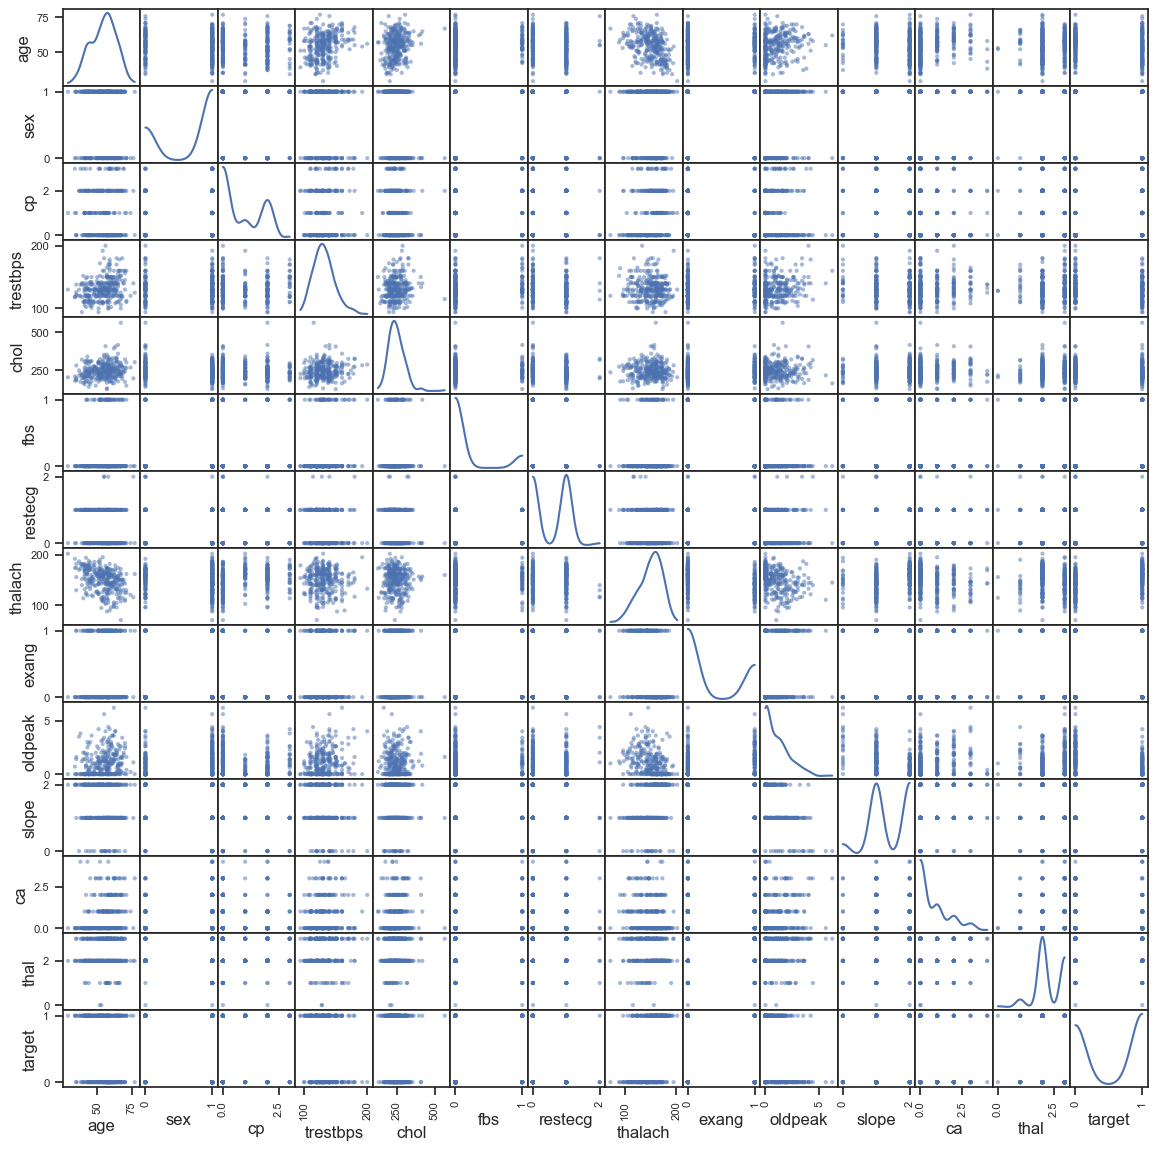

In [13]:
# Step 7: Make plots
scatter_matrix(dataset, figsize = (14, 14), diagonal = "kde", range_padding = 0.16);

I chose a scatter matrix for my first visualization because it can offer a high level overview of the features in the dataset and how they relate to each other. However, $14 * 14$ features is a lot to show in one plot, so this can be a difficult point to make strong assumptions about the data just yet.

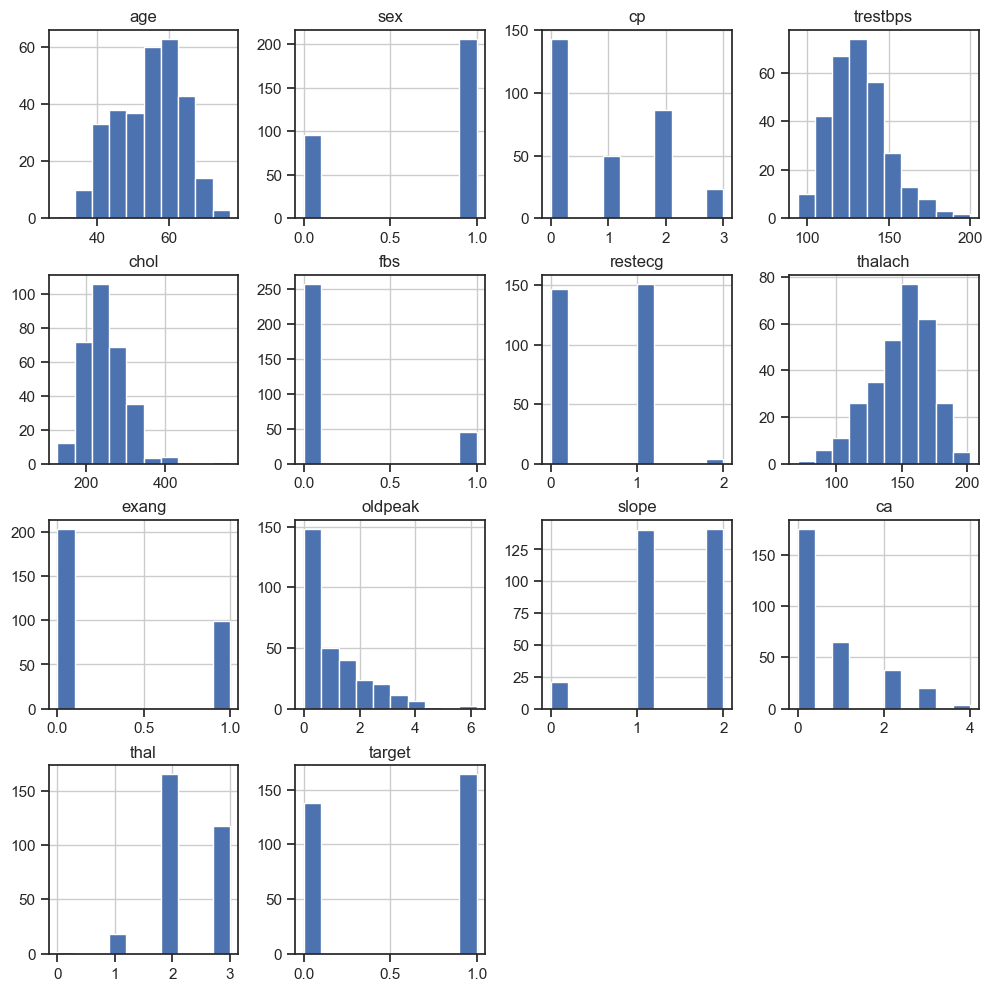

In [14]:
dataset.hist(figsize = (12, 12));
plt.show()

Looking at the histogram plots above, the continuous variables ("age", "trestbps", "chol", "thalach", "oldpeak") are more readily apparent. Only the "age" column seems to be nearly normally distributed whereas all the other continuous variables are skewed 3 to the left and 1 to the right.

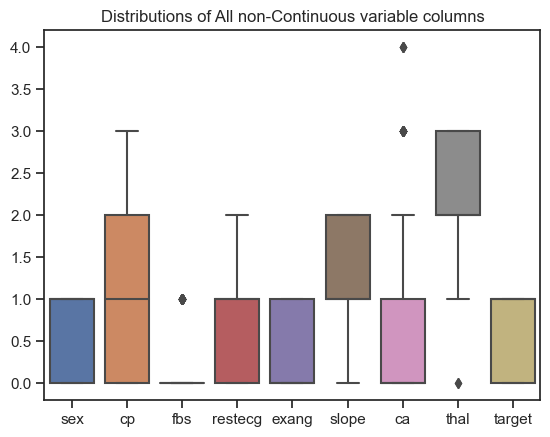

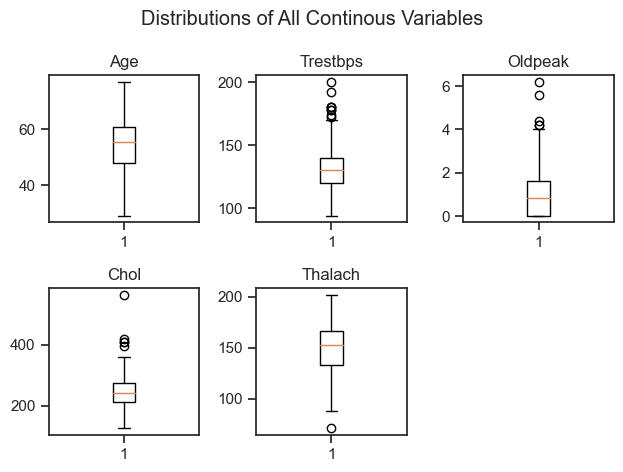

In [15]:
cont_columns = ["age", "trestbps", "chol", "thalach", "oldpeak"]
not_cont_columns = [col for col in dataset.columns if col not in cont_columns]

sns.boxplot(dataset[not_cont_columns])
plt.title("Distributions of All non-Continuous variable columns")
plt.show()


# Plot all continuous variables
fig, ax = plt.subplots(2, 3)
fig.suptitle("Distributions of All Continous Variables")

ax[0, 0].boxplot(dataset["age"])
ax[0, 0].set_title("Age")

ax[0, 1].boxplot(dataset["trestbps"])
ax[0, 1].set_title("Trestbps")

ax[0, 2].boxplot(dataset["oldpeak"])
ax[0, 2].set_title("Oldpeak")

ax[1, 0].boxplot(dataset["chol"])
ax[1, 0].set_title("Chol")

ax[1, 1].boxplot(dataset["thalach"])
ax[1, 1].set_title("Thalach")

fig.delaxes(ax[1, 2])
plt.tight_layout()
plt.show()

Judging by the boxplots above, we can now see that the dataset contains outliers which are already skewing the results of our analysis. So I'm going to calculate upper and lower bounds to create a subset of the dataset which contains no points outside of the $Q1 - (IQR * 1.5)$ and $Q3 + (IQR * 1.5)$ boundary.

In [16]:
# Step 5.3: Remove Outliers
no_outs = remove_outliers(dataset, 0.25, 0.75).dropna(subset = cont_columns)

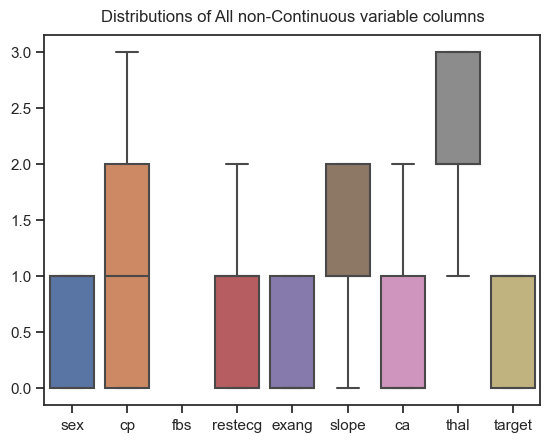

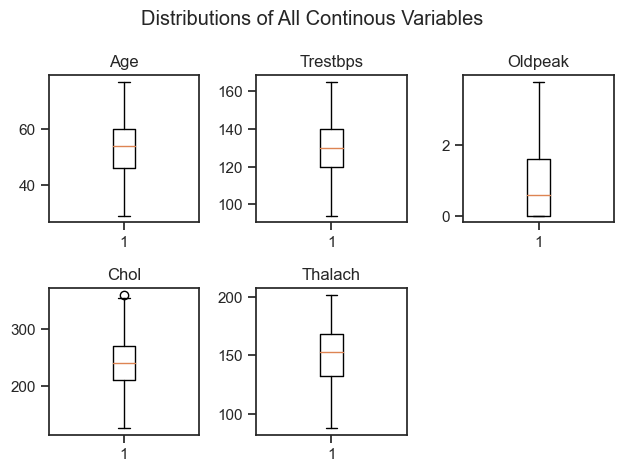

In [17]:
sns.boxplot(no_outs[not_cont_columns])
plt.title("Distributions of All non-Continuous variable columns", pad = 10.0)
plt.show()

# Plot all continuous variables
fig, ax = plt.subplots(2, 3)
fig.suptitle("Distributions of All Continous Variables")

ax[0, 0].boxplot(no_outs["age"])
ax[0, 0].set_title("Age")

ax[0, 1].boxplot(no_outs["trestbps"])
ax[0, 1].set_title("Trestbps")

ax[0, 2].boxplot(no_outs["oldpeak"])
ax[0, 2].set_title("Oldpeak")

ax[1, 0].boxplot(no_outs["chol"])
ax[1, 0].set_title("Chol")

ax[1, 1].boxplot(no_outs["thalach"])
ax[1, 1].set_title("Thalach")

fig.delaxes(ax[1, 2])
plt.tight_layout()
plt.show()

There is a marked difference in the means of the continuous variables which would suggest that removing the outliers from the dataset has made our dataset more rigorous for analysis.

In [18]:
corr_matrix = no_outs.corr()

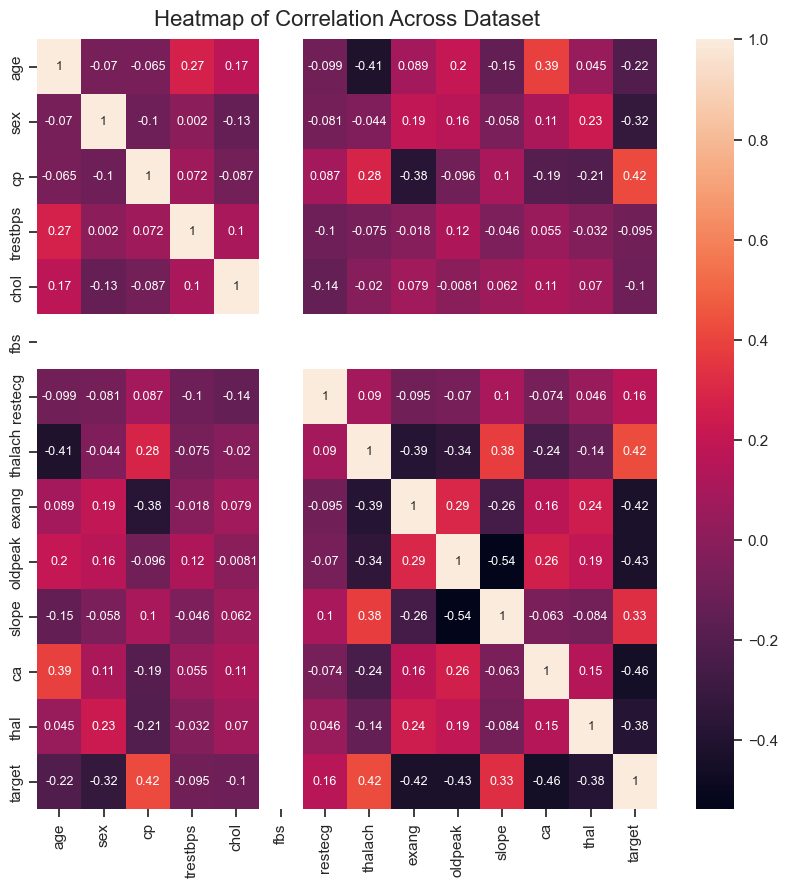

In [19]:
plt.figure(figsize = (10, 10))
sns.heatmap(corr_matrix, annot = True, annot_kws = {"size": 9})
plt.title("Heatmap of Correlation Across Dataset", pad = 10.0, fontsize = 16.0);

The above heatmap has similar comprehension issues as the scatter matrix before, however the graph's annotations make establishing correlation between two variables much easier. For the purposes of this analysis, I will focus on the correlations as they relate to the "target" column. 

Below, I'm going to visualize a correlation matrix using a subset of the data which contains the continuous variables and the "target" column, this more granular visualization should make it much easier to spot the continuous variables that are most positively correlated with the "target" column.

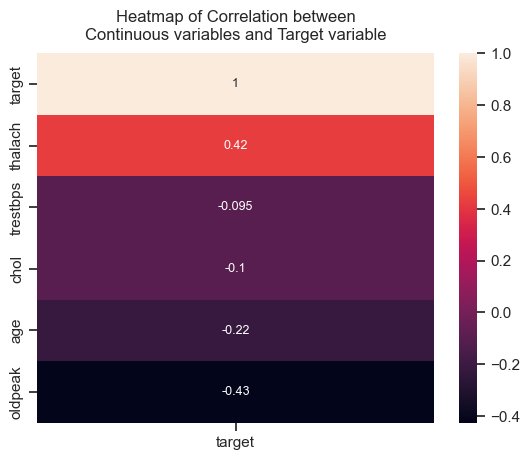

In [20]:
target_corr_matrix = pd.DataFrame(corr_matrix[cont_columns + ["target"]].T["target"].sort_values(ascending = False))
sns.heatmap(target_corr_matrix, annot = True, annot_kws = {"size": 9})
plt.title("Heatmap of Correlation between\nContinuous variables and Target variable", pad = 10.0);
plt.show()

<strong>QUESTION: WHAT ARE THE TOP 2 CAUSE OF HEART DISEASE BASED ON YOUR EDA OF CLEVELAND HEART DISEASE DATASET?</strong></br>

According to my preliminary data cleaning and visualizations, the top 2 causes of heart disease are:<br>
&emsp;&emsp;1. **Maximum Heart Rate Achieved (aka "Thalach")** at $0.42$<br>
&emsp;&emsp;2. **Resting Blood Pressure (in mmHg) (aka "Trestbps")** at $-0.95$<br>

This preliminary analysis would suggest that "Thalach" is strongly positively correlated with heart disease diagnosis and "Trestbps" is slightly negatively correlated with heart disease diagnosis.

## Section 2: Hypothesis Testing

For the hypothesis testing portion of this assignment, I will be using the Critical Value Approach. This requires referencing a T-table to find an appropriate value for establishing whether or not there is a statistically significant relationship between 2 distributions. I've written hypotheses for both **Maximum Heart Rate Achieved (aka "Thalach")** and **Resting Blood Pressure (in mmHg) (aka "Trestbps")** respectively.

__________
Test 1: <strong>Thalach</strong><br>

Null Hypothesis, H0:<br>
&emsp;&emsp;There is no statistically significant linear relationship between the "target" column and the "thalach" column.

Alternative Hypothesis, HA:<br>
&emsp;&emsp;The calculated T-value is greater than the T-table value, suggesting that there is a statistically significant linear relationship between the "target" column and the "thalach" column.

__________
Test 2: <strong>Trestbps</strong><br>

Null Hypothesis, H0:<br>
&emsp;&emsp;There is no statistically significant linear relationship between the "target" column and the "trestbps" column.

Alternative Hypothesis, HA:<br>
&emsp;&emsp;The calculated T-value is greater than the T-table value, suggesting that there is a statistically significant linear relationship between the "target" column and the "trestbps" column.

In [21]:
# Step 0: Subset the continuous variables
cont_subset = no_outs[cont_columns + ["target"]]

In [22]:
# Step 1 & 3: Calculates covariance and subsets for the most positively correlated features.
thalach = cont_subset["thalach"]
trestbps = cont_subset["trestbps"]
target_y = cont_subset["target"]

covar_to_target = partial(calc_covar, target_y)

thalac_covar = covar_to_target(thalach)
trestbps_covar = covar_to_target(trestbps)

print(f"Covariance (thalach, target): {thalac_covar:.3f}")
print(f"Covariance (trestbps, target): {trestbps_covar:.3f}")

Covariance (thalach, target): 4.826
Covariance (trestbps, target): -0.698


Above, I have isolated the variables "thalach", "trestbps", and "target" for comparison and hypothesis testing. After calculating the covariance as it relates to the "target" column, "thalach" has a covariance of $4.826$ and "trestbps" has a covariance of $-0.698$. 

Covariance indicates the relationship between variables when one variable changes. For example, if "thalach" increasing results in an increase in "target" this would indicate a positive relationship between the variables. Trestbps has a covariance slightly below zero, suggesting that there isn't a strong relationship between a decrement in "trestbps" and an increase in "target".

In [23]:
# Step 2: Calculates correlation
corr_to_target = partial(calc_corr, target_y)

thalach_corr = corr_to_target(thalach)
trestbps_corr = corr_to_target(trestbps)

print(f"Correlation (thalach, target): {thalach_corr:.3f}")
print(f"Correlation (trestbps, target): {trestbps_corr:.3f}")

Correlation (thalach, target): 0.426
Correlation (trestbps, target): -0.096


Correlation indicates the extent to which two variables are linearly related, meaning that both variables change at a constant rate relative to each other. 

The correlation between "thalach" and "target" is $0.426$ which corresponds to the smaller heatmap in my previous data visualizations. This suggests that there is a positive linear relationship between the two variables.

The correlation between "trestbps" and "target" is $-0.096$ which also corresponds to the same, smaller heatmap from before. The correlation coefficient suggests that there is nearly no linear relationship between the "trestbps" and "target".
__________

My predictions for the hypothesis testing are as follows:

&emsp;&emsp;&emsp;<strong>Maximum Heart Rate Achieved:</strong> I expect that there is a statistically significant linear relationship between the "thalach" and "target" column, rejecting the null hypothesis.<br><br>
&emsp;&emsp;&emsp;<strong>Resting Blood Pressure (in mmHg):</strong> I anticipate that there is not a statistically significant linear relationship between the "trestbps" and "target" column. Therefore, I will not be able to reject the null hypothesis.

<AxesSubplot: >

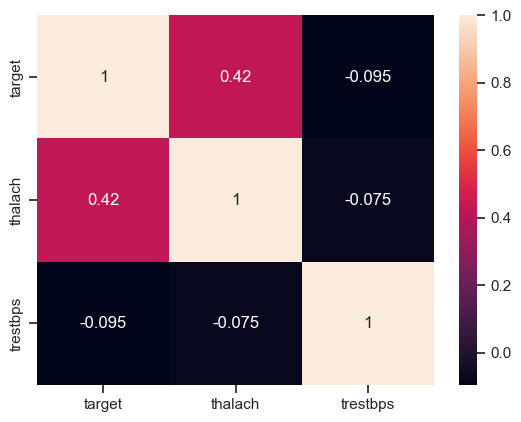

In [24]:
sns.heatmap(cont_subset[["target", "thalach", "trestbps"]].corr(), annot = True)

This heatmap uses the correlation calculation available in DataFrames as a means to check the validity of my calculated correlations. My values seem to align quite closely with the valid correlations and this satisfies me enough to carry on with the hypothesis testing.

In [25]:
# Step 4: Null Hypothesis
t_value = 1.7613
h_test = partial(hypothesis_test, t_table_value = t_value)

thalach_t = calc_t(thalach_corr, thalach.size)
trestbps_t = calc_t(trestbps_corr, trestbps.size)

print("Test 1 (Thalach):")
h_test(thalach_t)

print("\nTest 2 (Trestbps):")
h_test(trestbps_t)

Test 1 (Thalach):
Reject the Null Hypothesis in favor of the Alternative Hypothesis.

Test 2 (Trestbps):
Cannot Reject the Null Hypothesis.


## Conclusions

Using a T-table value of $1.7613$ to obtain a right tail test with an alpha of $0.05$, I conclude that there is a statistically significant linear relationship the between Maximum Heart Rate Achieved (aka "thalach") and Heart Disease Outcomes (aka "target"). However, between Resting Blood Pressure (in mmHg) (aka "trestbps") and Heart Disease Outcomes ("target"), the Null Hypothesis could not be rejected. In other words, no statistically significant linear relationship was identified between them.

__________

According to the Heart Disease dataset from the UC Irving Machine Learning Repository, the answers to the question **"Which 2 continuous variables are most correlated with the diagnosis of heart disease?"** are **Maximum Heart Rate Achieved** and **Resting Blood Pressure (in mmHg)**.

The relationship between heart disease diagnosis and Maximum Heart Rate Achieved is positively correlated and I was able to reject the null hypothesis in favor of the alternative hypothesis. On the other hand, the relationship between heart disease diagnosis and Resting Blood Pressure (in mmHg) is barely negatively correlated and I was unable to reject the null hypothesis. 